In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
from itertools import cycle

from Models import KeypointNet, KeypointDataset
from Helper import save_checkpoint_generic, load_checkpoint_generic
from Generator import generate_synthetic_image


In [2]:
# ============================================================
# HYPERPARAMETERS
# ============================================================

# Model parameters (SuperPoint: Adam, lr=0.001, beta=(0.9, 0.999))
learning_rate = 0.001
adam_betas = (0.9, 0.999)
weight_decay = 0.0

# Training parameters (iteration-based)
num_iterations = 200_000  # SuperPoint uses 200k iterations
batch_size = 16  # SuperPoint uses 32

# Image parameters
image_size = (240, 320)  # (Height, Width)

# Dataset parameters
num_train_samples = 5000  # Number of pregenerated training samples
num_test_samples = 500  # Number of pregenerated test samples

# Augmentation settings (applied during training, not during generation)
use_homography_augment = True  # Apply random homography to training data
use_photometric_augment = True  # Apply brightness/contrast to training data
use_geometric_augment = True  # Apply flips to training data

# Dataset file paths (.npz format - contains pregenerated images)
dataset_cache_dir = './datasets'
load_datasets_if_exist = True  # Load from .npz files if available

# Checkpoint parameters
checkpoint_dir = './checkpoints'
save_checkpoint_every = 5000  # Save every N iterations
max_checkpoints = 4

# Logging parameters
eval_every = 100  # Evaluate on test set every N iterations
print_every = 10

# Create directories
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(dataset_cache_dir, exist_ok=True)

print("✓ Configuration loaded")
print(f"  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"  Training samples: {num_train_samples}")
print(f"  Test samples: {num_test_samples}")
print(f"  Batch size: {batch_size}")
print(f"  Target iterations: {num_iterations:,}")
print(f"  Training augmentation: {'ENABLED' if use_homography_augment else 'DISABLED'}")
print()


✓ Configuration loaded
  Device: CUDA
  Training samples: 5000
  Test samples: 500
  Batch size: 16
  Target iterations: 200,000
  Training augmentation: ENABLED



In [3]:
# ============================================================
# DATASET GENERATION AND SAVING (Run once to create datasets)
# ============================================================

def generate_and_save_datasets():
    train_samples_path = os.path.join(dataset_cache_dir, f'train_samples_{num_train_samples}.npz')
    test_samples_path = os.path.join(dataset_cache_dir, f'test_samples_{num_test_samples}.npz')

    print("=" * 60)
    print("DATASET GENERATION")
    print("=" * 60)
    print()

    # Generate and save training samples (raw, no augmentation)
    print(f"Generating {num_train_samples} training samples...")
    train_generator = KeypointDataset(
        num_samples=num_train_samples,
        image_shape=image_size,
        generate_fn=generate_synthetic_image,
        generate_kwargs={
            'width': image_size[1],
            'height': image_size[0],
            'shape_type': 'random',
            'grayscale': True
        },
        use_homography_augment=False,
        use_photometric_augment=False,
        use_geometric_augment=False,
        pregenerate=True
    )
    print(f"✓ Training samples generated: {len(train_generator)} samples")

    # Save training samples
    print(f"Saving to {train_samples_path}...")
    train_generator.save_to_file(train_samples_path)
    print(f"✓ Training samples saved!")
    print()

    # Generate and save test samples (raw, no augmentation)
    print(f"Generating {num_test_samples} test samples...")
    test_generator = KeypointDataset(
        num_samples=num_test_samples,
        image_shape=image_size,
        generate_fn=generate_synthetic_image,
        generate_kwargs={
            'width': image_size[1],
            'height': image_size[0],
            'shape_type': 'random',
            'grayscale': True
        },
        use_homography_augment=False,
        use_photometric_augment=False,
        use_geometric_augment=False,
        pregenerate=True
    )
    print(f"✓ Test samples generated: {len(test_generator)} samples")

    # Save test samples
    print(f"Saving to {test_samples_path}...")
    test_generator.save_to_file(test_samples_path)
    print(f"✓ Test samples saved!")
    print()

    print("=" * 60)
    print("✓ Dataset generation complete!")
    print("=" * 60)
    print(f"Training samples: {train_samples_path}")
    print(f"Test samples: {test_samples_path}")
    print()

# generate_and_save_datasets()


In [4]:
# ============================================================
# LOAD DATASETS AND INIT MODEL
# ============================================================

print("=" * 60)
print("TRAINING SETUP")
print("=" * 60)
print()

# ============================================================
# LOAD DATASETS FROM .NPZ FILES
# ============================================================

train_samples_path = os.path.join(dataset_cache_dir, f'train_samples_{num_train_samples}.npz')
test_samples_path = os.path.join(dataset_cache_dir, f'test_samples_{num_test_samples}.npz')

train_dataset = None
test_dataset = None

# Load training dataset WITH augmentation
if load_datasets_if_exist and os.path.exists(train_samples_path):
    print(f"Loading training samples from {train_samples_path}...")
    print(f"  Augmentation: {'ENABLED' if use_homography_augment else 'DISABLED'}")
    try:
        train_dataset = KeypointDataset(
            num_samples=num_train_samples,
            image_shape=image_size,
            use_homography_augment=use_homography_augment,
            use_photometric_augment=use_photometric_augment,
            use_geometric_augment=use_geometric_augment,
            pregenerate=False,  # Don't regenerate, just load
            load_from_file=train_samples_path
        )
        print(f"✓ Training dataset loaded: {len(train_dataset)} samples")
    except Exception as e:
        print(f"⚠️  Failed to load training dataset: {e}")
        print("Please run the dataset generation cell first!")
        train_dataset = None
else:
    print(f"⚠️  Training samples not found at {train_samples_path}")
    print("Please run the dataset generation cell first!")

# Load test dataset WITHOUT augmentation
if load_datasets_if_exist and os.path.exists(test_samples_path):
    print(f"Loading test samples from {test_samples_path}...")
    # print(f"  Augmentation: {'ENABLED' if use_homography_augment else 'DISABLED'} (test set)")
    try:
        test_dataset = KeypointDataset(
            num_samples=num_test_samples,
            image_shape=image_size,
            # use_homography_augment=False,
            # use_photometric_augment=False,
            # use_geometric_augment=False,
            pregenerate=False,
            # load_from_file=test_samples_path
        )
        print(f"✓ Test dataset loaded: {len(test_dataset)} samples")
    except Exception as e:
        print(f"⚠️  Failed to load test dataset: {e}")
        print("Please run the dataset generation cell first!")
        test_dataset = None
else:
    print(f"⚠️  Test samples not found at {test_samples_path}")
    print("Please run the dataset generation cell first!")

# Check if datasets were loaded successfully
if train_dataset is None or test_dataset is None:
    print()
    print("=" * 60)
    print("⚠️  ERROR: Datasets not loaded!")
    print("=" * 60)
    print("Please run Cell 3 (Dataset Generation) first to create the .npz files.")
    print()
    raise RuntimeError("Datasets not found. Run dataset generation cell first.")

print()

# ============================================================
# CREATE DATALOADERS
# ============================================================

print("Creating DataLoaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"✓ DataLoaders created")
print(f"  Training batches per epoch: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")
print()

# ============================================================
# MODEL INITIALIZATION
# ============================================================

print("Initializing model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = KeypointNet().to(device)

# Optimizer (SuperPoint paper: Adam with lr=0.001, betas=(0.9, 0.999))
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    betas=adam_betas,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50_000, gamma=0.5)


TRAINING SETUP

Loading training samples from ./datasets\train_samples_5000.npz...
  Augmentation: ENABLED
Loading 5000 samples from ./datasets\train_samples_5000.npz...
✓ Loaded 5000 samples!
✓ Training dataset loaded: 5000 samples
Loading test samples from ./datasets\test_samples_500.npz...
✓ Test dataset loaded: 500 samples

Creating DataLoaders...
✓ DataLoaders created
  Training batches per epoch: 313
  Test batches: 32

Initializing model...
Using device: cuda


In [5]:
# ============================================================
# TRAINING LOOP (modified: soft-label loss, per-cell norm,
# positive-cell weighting, safe scheduler step, gradient clipping)
# ============================================================

# Loss tracking
train_losses = []
test_losses = []
start_iteration = 0

# Load checkpoint if exists
checkpoint = load_checkpoint_generic(checkpoint_dir, device)
if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iteration = checkpoint.get('iteration', 0)
    train_losses = checkpoint.get('train_losses', [])
    test_losses = checkpoint.get('test_losses', [])
    print(f"✓ Resuming from iteration {start_iteration:,}")
else:
    print("✓ Starting from scratch")

print()
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)
print()

# ============================================================
# ITERATION-BASED TRAINING LOOP (with soft-label CE + weighting)
# ============================================================

# Hyperparams for loss balancing (tuneable)
pos_cell_weight = 5.0  # weight multiplier for cells that contain any keypoint (>=1.0)
gaussian_sigma = 1.0  # kept for reference if you change generator
clip_grad_norm = 5.0  # gradient clipping
use_pos_weighting = True  # toggle positive-cell weighting

model.train()
running_loss = 0.0
iteration = start_iteration

# Create iterator for infinite cycling through dataset
train_iterator = cycle(train_loader)


# Helper: soft cross-entropy (per-cell mean)
def soft_cross_entropy_from_logits(logits, soft_targets, pos_weighting=True, pos_mult=5.0):
    """
    logits: (B, C, Hc, Wc)
    soft_targets: (B, C, Hc, Wc) - floats (not necessarily normalized)
    Returns scalar loss averaged over all cells and batch.
    """
    # ensure device/dtype consistency
    soft_targets = soft_targets.type_as(logits).to(logits.device)

    # Normalize per-cell so each cell's channels sum to 1 (makes targets valid distributions)
    s = soft_targets.sum(dim=1, keepdim=True)  # (B,1,Hc,Wc)
    s = torch.where(s <= 0.0, torch.ones_like(s), s)  # avoid division by zero
    targets_norm = soft_targets / s

    # log-probabilities over channels
    log_probs = F.log_softmax(logits, dim=1)  # (B,C,Hc,Wc)

    # per-cell loss = - sum_c target_c * log_probs_c
    per_cell_loss = - (targets_norm * log_probs).sum(dim=1)  # (B,Hc,Wc)

    # optional positive-cell weighting
    if pos_weighting:
        pos_mask = (targets_norm[:, :64].sum(dim=1) > 0).float()  # (B,Hc,Wc)
        neg_mask = 1.0 - pos_mask
        weights = neg_mask + pos_mult * pos_mask
        per_cell_loss = per_cell_loss * weights

    # final scalar: mean across batch & cells
    return per_cell_loss.mean()


# Main loop
while iteration < num_iterations:
    # Get next batch (infinite cycling)
    images, targets = next(train_iterator)

    # Move to device
    images = images.to(device)
    targets = targets.to(device)

    # Sanity checks for shapes (run once after resume/start)
    if iteration == start_iteration:
        assert images.dim() == 4 and images.shape[1] == 1, f"Images must be (B,1,H,W). Got {images.shape}"
        assert targets.dim() == 4 and targets.shape[1] == 65, f"Targets must be (B,65,Hc,Wc). Got {targets.shape}"
        print("Sanity check passed (shapes):", images.shape, targets.shape)

    # Forward pass (raw logits)
    logits = model(images, return_logits=True)  # (B, 65, Hc, Wc)

    # Sanity: shape match
    assert logits.dim() == 4 and targets.dim() == 4, f"Unexpected dims: logits {logits.shape}, targets {targets.shape}"
    B, C, Hc, Wc = logits.shape
    assert C == 65, f"Expected 65 channels, got {C}"
    assert targets.shape == (B, C, Hc, Wc), f"Target shape mismatch: {targets.shape} vs logits {logits.shape}"

    # Compute soft-label cross-entropy (with per-cell normalization and pos weighting)
    loss = soft_cross_entropy_from_logits(logits, targets, pos_weighting=use_pos_weighting, pos_mult=pos_cell_weight)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    # gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
    optimizer.step()
    scheduler.step()

    # Print progress
    iteration += 1
    running_loss += loss.item()

    # Print training loss (averaged over print_every iters)
    if iteration % print_every == 0:
        avg_loss = running_loss / print_every
        running_loss = 0.0
        train_losses.append(avg_loss)
        print(f"Iter [{iteration:>6}/{num_iterations}] Loss: {avg_loss:.4f}")

    # Evaluate on test set
    if iteration % eval_every == 0:
        model.eval()
        test_loss = 0.0
        num_test_batches = 0

        with torch.no_grad():
            for test_images, test_targets in test_loader:
                test_images = test_images.to(device)
                test_targets = test_targets.to(device)

                logits_val = model(test_images, return_logits=True)

                # Evaluate with same soft loss logic (normalize per-cell & weighting)
                loss_val = soft_cross_entropy_from_logits(logits_val, test_targets,
                                                          pos_weighting=use_pos_weighting,
                                                          pos_mult=pos_cell_weight)

                test_loss += loss_val.item()
                num_test_batches += 1

        avg_test_loss = test_loss / max(1, num_test_batches)
        test_losses.append(avg_test_loss)
        print(f"  └─ Test Loss: {avg_test_loss:.4f}")
        model.train()

    # Save checkpoint
    if iteration % save_checkpoint_every == 0 or iteration == num_iterations:
        save_checkpoint_generic(
            checkpoint_dir,
            iteration,
            {
                'iteration': iteration,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'test_losses': test_losses,
                'config': {
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'num_iterations': num_iterations,
                    'eval_every': eval_every,
                    'print_every': print_every,
                    'image_size': image_size,
                }
            },
            max_checkpoints=max_checkpoints
        )
        print(f"  └─ Checkpoint saved")

print()
print("=" * 60)
print("✓ TRAINING COMPLETE!")
print("=" * 60)
if len(train_losses) > 0:
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
if len(test_losses) > 0:
    print(f"Final Test Loss: {test_losses[-1]:.4f}")
print()


✅ Loaded checkpoint: ./checkpoints\checkpoint_epoch_115000.pth (epoch 115000)
✓ Resuming from iteration 115,000

STARTING TRAINING

Sanity check passed (shapes): torch.Size([16, 1, 240, 320]) torch.Size([16, 65, 30, 40])
Iter [115010/200000] Loss: 0.0983
Iter [115020/200000] Loss: 0.0824
Iter [115030/200000] Loss: 0.0801
Iter [115040/200000] Loss: 0.0729
Iter [115050/200000] Loss: 0.0907
Iter [115060/200000] Loss: 0.0734
Iter [115070/200000] Loss: 0.0707
Iter [115080/200000] Loss: 0.0755
Iter [115090/200000] Loss: 0.0809
Iter [115100/200000] Loss: 0.0774
  └─ Test Loss: 0.0791
Iter [115110/200000] Loss: 0.0753
Iter [115120/200000] Loss: 0.0778
Iter [115130/200000] Loss: 0.0732
Iter [115140/200000] Loss: 0.0820
Iter [115150/200000] Loss: 0.0667
Iter [115160/200000] Loss: 0.0751
Iter [115170/200000] Loss: 0.0716
Iter [115180/200000] Loss: 0.0775
Iter [115190/200000] Loss: 0.0729
Iter [115200/200000] Loss: 0.0724
  └─ Test Loss: 0.0759
Iter [115210/200000] Loss: 0.0735
Iter [115220/200000

✅ Loaded checkpoint: ./checkpoints\checkpoint_epoch_200000.pth (epoch 200000)
✓ Loaded training history from checkpoint (iteration 200,000)
TRAINING VISUALIZATION

✓ Training losses plotted (20000 points, every 10 iterations)
  Range: iteration 10 to 200,000
✓ Test losses plotted (2000 points, every 100 iterations)
  Range: iteration 100 to 200,000


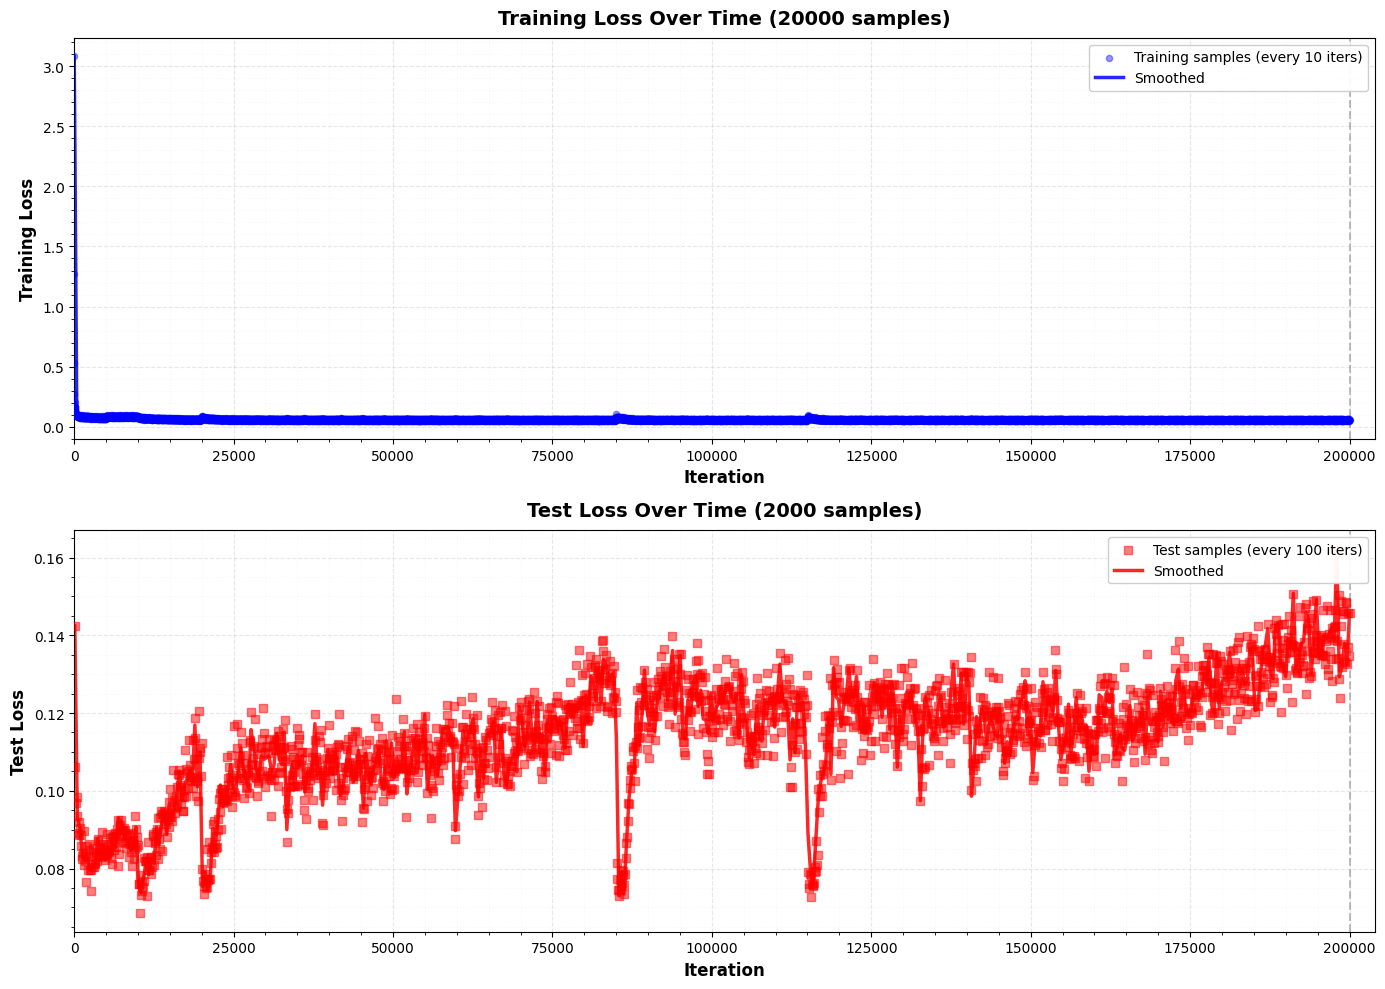


STATISTICS
Checkpoint iteration: 200,000

Sampling rates:
  Training loss: every 10 iterations (20000 samples)
  Test loss:     every 100 iterations (2000 samples)

Training Loss:
  Final: 0.059509 (at iteration 200,000)
  Best:  0.048690 (at iteration 70,090)

Test Loss:
  Final: 0.145735 (at iteration 200,000)
  Best:  0.068428 (at iteration 10,400)



In [5]:
# ============================================================
# IMPROVED PLOT TRAINING CURVES - SEPARATE GRAPHS
# ============================================================
# Copy this code into a new cell in your notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load checkpoint to get training history
checkpoint_dir = './checkpoints'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = load_checkpoint_generic(checkpoint_dir, device)
if checkpoint:
    train_losses = checkpoint.get('train_losses', [])
    test_losses = checkpoint.get('test_losses', [])
    print_every = checkpoint['config']['print_every']
    eval_every = checkpoint['config']['eval_every']
    iteration = checkpoint['iteration']
    print(f"✓ Loaded training history from checkpoint (iteration {iteration:,})")
else:
    raise ValueError("No checkpoint found for plotting training curves.")

print("=" * 60)
print("TRAINING VISUALIZATION")
print("=" * 60)
print()

if len(train_losses) == 0 and len(test_losses) == 0:
    print("⚠️  No training data to plot. Run the training loop first.")
else:
    # Calculate actual iteration numbers for each loss point
    train_iterations = np.array([(i + 1) * print_every for i in range(len(train_losses))])
    test_iterations = np.array([(i + 1) * eval_every for i in range(len(test_losses))])

    # Create figure with TWO separate subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # ============================================================
    # PLOT 1: TRAINING LOSS
    # ============================================================
    if len(train_losses) > 0:
        # Plot raw data points
        ax1.scatter(train_iterations, train_losses, c='blue', s=20, alpha=0.4,
                    label=f'Training samples (every {print_every} iters)', zorder=3)

        # Smooth with moving average or interpolation (NO extrapolation)
        if len(train_losses) > 5:
            # Interpolate ONLY within the actual data range
            smooth_iterations = np.linspace(train_iterations[0], train_iterations[-1], 500)
            train_interpolator = interp1d(train_iterations, train_losses, kind='cubic')
            smooth_train = train_interpolator(smooth_iterations)
            ax1.plot(smooth_iterations, smooth_train, 'b-',
                     label='Smoothed', linewidth=2.5, alpha=0.85)
        else:
            # If too few points, just connect them
            ax1.plot(train_iterations, train_losses, 'b-', linewidth=2, alpha=0.85)

        # Formatting
        ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
        ax1.set_title(f'Training Loss Over Time ({len(train_losses)} samples)',
                      fontsize=14, fontweight='bold', pad=10)
        ax1.legend(fontsize=10, loc='upper right', framealpha=0.95)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.minorticks_on()
        ax1.grid(which='minor', alpha=0.1, linestyle=':')
        ax1.ticklabel_format(style='plain', axis='x')

        # Set x-limit to actual data range (no extrapolation!)
        ax1.set_xlim(0, train_iterations[-1] * 1.02)

        # Add vertical line at current iteration
        if iteration <= train_iterations[-1]:
            ax1.axvline(x=iteration, color='gray', linestyle='--', linewidth=1.5,
                        alpha=0.5, label=f'Current: {iteration:,}')

        print(f"✓ Training losses plotted ({len(train_losses)} points, every {print_every} iterations)")
        print(f"  Range: iteration {train_iterations[0]:,} to {train_iterations[-1]:,}")

    # ============================================================
    # PLOT 2: TEST LOSS
    # ============================================================
    if len(test_losses) > 0:
        # Plot raw data points
        ax2.scatter(test_iterations, test_losses, c='red', s=40, alpha=0.5,
                    marker='s', label=f'Test samples (every {eval_every} iters)', zorder=3)

        # Smooth with interpolation (NO extrapolation)
        if len(test_losses) > 5:
            # Interpolate ONLY within the actual data range
            smooth_test_iterations = np.linspace(test_iterations[0], test_iterations[-1], 500)
            test_interpolator = interp1d(test_iterations, test_losses, kind='cubic')
            smooth_test = test_interpolator(smooth_test_iterations)
            ax2.plot(smooth_test_iterations, smooth_test, 'r-',
                     label='Smoothed', linewidth=2.5, alpha=0.85)
        else:
            # If too few points, just connect them
            ax2.plot(test_iterations, test_losses, 'r-', linewidth=2, alpha=0.85)

        # Formatting
        ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Test Loss', fontsize=12, fontweight='bold')
        ax2.set_title(f'Test Loss Over Time ({len(test_losses)} samples)',
                      fontsize=14, fontweight='bold', pad=10)
        ax2.legend(fontsize=10, loc='upper right', framealpha=0.95)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.minorticks_on()
        ax2.grid(which='minor', alpha=0.1, linestyle=':')
        ax2.ticklabel_format(style='plain', axis='x')

        # Set x-limit to actual data range (no extrapolation!)
        ax2.set_xlim(0, test_iterations[-1] * 1.02)

        # Add vertical line at current iteration
        if iteration <= test_iterations[-1]:
            ax2.axvline(x=iteration, color='gray', linestyle='--', linewidth=1.5,
                        alpha=0.5, label=f'Current: {iteration:,}')

        print(f"✓ Test losses plotted ({len(test_losses)} points, every {eval_every} iterations)")
        print(f"  Range: iteration {test_iterations[0]:,} to {test_iterations[-1]:,}")

    plt.tight_layout()
    plt.show()

    # ============================================================
    # STATISTICS
    # ============================================================
    print()
    print("=" * 60)
    print("STATISTICS")
    print("=" * 60)
    print(f"Checkpoint iteration: {iteration:,}")
    print()
    print(f"Sampling rates:")
    print(f"  Training loss: every {print_every} iterations ({len(train_losses)} samples)")
    print(f"  Test loss:     every {eval_every} iterations ({len(test_losses)} samples)")
    print()

    if len(train_losses) > 0:
        best_train_idx = np.argmin(train_losses)
        print("Training Loss:")
        print(f"  Final: {train_losses[-1]:.6f} (at iteration {train_iterations[-1]:,})")
        print(f"  Best:  {train_losses[best_train_idx]:.6f} (at iteration {train_iterations[best_train_idx]:,})")
        print()

    if len(test_losses) > 0:
        best_test_idx = np.argmin(test_losses)
        print("Test Loss:")
        print(f"  Final: {test_losses[-1]:.6f} (at iteration {test_iterations[-1]:,})")
        print(f"  Best:  {test_losses[best_test_idx]:.6f} (at iteration {test_iterations[best_test_idx]:,})")
        print()

    print("=" * 60)


35k changed test dataset
random test dataset evaluation
